# *Assignment 2: Practical Model Optimization*
## Portfolio 2 : Computer vision
## Group Members: Prahas Hegde, Rohan Sanjay Patil, Vidya Padmanabha


## SETUP and CONFIGURATION

*   Device Setup
*   Hyperparameters

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import time
import os
import zipfile  # <--- Added for size calculation
import matplotlib.pyplot as plt
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
PRUNING_AMOUNT = 0.5
ITERATIVE_STEPS = 5

#DATA LOADING
* Data augmentation transforms
* Train and test loaders

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

if not os.path.exists('./data'):
    os.makedirs('./data')

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 35.3MB/s]


# MODEL UTILITIES


In [3]:
def get_model():
    # Keeping ResNet18 as requested
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, 10)
    return model.to(DEVICE)

def get_model_size(model, filename="temp_model.pth"):
    """
    Calculates the COMPRESSED model size in MB.
    This effectively demonstrates the size reduction from pruning.
    """
    # 1. Save the model state dict (weights only)
    torch.save(model.state_dict(), filename)

    # 2. Zip the file (zeros compress better than random numbers)
    zip_filename = filename + '.zip'
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
        zf.write(filename)

    # 3. Get compressed size (in MB)
    compressed_size_mb = os.path.getsize(zip_filename) / 1024**2

    # 4. Clean up temp files
    if os.path.exists(filename): os.remove(filename)
    if os.path.exists(zip_filename): os.remove(zip_filename)

    return compressed_size_mb

def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    end_time = time.time()
    return 100. * correct / total, (end_time - start_time) / len(testloader)

def fine_tune(model, epochs=1):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()

def count_sparsity(model):
    total, zero = 0, 0
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            w = module.weight
            total += w.nelement()
            zero += torch.sum(w == 0).item()
    if total == 0: return 0
    return 100. * zero / total

#PRUNING METHODS
* prune_l2_structured(): L2-norm based filter pruning
* prune_taylor_1st_order(): Taylor expansion importance

In [4]:
def prune_l2_structured(model, amount):
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0)

def prune_taylor_1st_order(model, amount, dataloader):
    """
    Corrected Taylor Pruning: Ensures previously pruned filters stay pruned.
    """
    model.eval()
    model.zero_grad()

    try:
        inputs, labels = next(iter(dataloader))
    except StopIteration:
        dataloader_iter = iter(dataloader)
        inputs, labels = next(dataloader_iter)

    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

    outputs = model(inputs)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    loss.backward()

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            if prune.is_pruned(module):
                current_mask = module.weight_mask.detach()
                w = module.weight_orig
            else:
                current_mask = torch.ones_like(module.weight).detach()
                w = module.weight

            if w.grad is None:
                continue

            # Calculate Importance
            raw_importance = (w * w.grad).abs()
            filter_importance = raw_importance.view(w.shape[0], -1).sum(dim=1)

            # Identify currently active filters
            is_active = (current_mask.view(w.shape[0], -1).sum(dim=1) > 0)

            if is_active.sum() == 0:
                continue

            # Set pruned filters to infinity so they aren't picked to be removed again
            filter_importance[~is_active] = float('inf')

            # Determine threshold
            num_active = is_active.sum().item()
            n_prune = int(amount * num_active)

            if n_prune < 1:
                continue

            topk = torch.topk(filter_importance, k=n_prune, largest=False)
            threshold = topk.values.max()

            # Ensure new mask respects the old 'is_active' state
            new_mask_1d = filter_importance.gt(threshold).float() * is_active.float()
            new_mask = new_mask_1d.view(-1, 1, 1, 1).expand_as(w)

            prune.custom_from_mask(module, name='weight', mask=new_mask)

def make_pruning_permanent(model):
    """
    Removes the re-parameterization (mask) and makes the pruning permanent.
    This is REQUIRED to see size reduction.
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            # Check if the module has been pruned (has the 'weight_orig' attribute)
            if hasattr(module, 'weight_orig'):
                prune.remove(module, 'weight')

#EXPERIMENT EXECUTION
* run_experiment(): Orchestrates pruning + fine-tuning

In [5]:
all_results = []

def run_experiment(name, strategy, target_sparsity):
    print(f"Running {name} - {strategy}...")
    model = get_model()
    fine_tune(model, epochs=1)

    # Baseline Metrics
    acc_b, time_b = evaluate(model)
    size_b = get_model_size(model)

    all_results.append({
        "Type": "Baseline",
        "Method": name,
        "Strategy": strategy,
        "Acc": acc_b,
        "Sparsity": 0.0,
        "Time": time_b,
        "Size": size_b
    })

    if strategy == "One-Shot":
        if name == "L2": prune_l2_structured(model, target_sparsity)
        else: prune_taylor_1st_order(model, target_sparsity, trainloader)
        fine_tune(model, epochs=1)
    else:
        step_amt = 1 - (1 - target_sparsity) ** (1 / ITERATIVE_STEPS)
        for _ in range(ITERATIVE_STEPS):
            if name == "L2": prune_l2_structured(model, step_amt)
            else: prune_taylor_1st_order(model, step_amt, trainloader)
            fine_tune(model, epochs=1)


    make_pruning_permanent(model)

    # Final Metrics
    acc_f, time_f = evaluate(model)
    size_f = get_model_size(model)

    all_results.append({
        "Type": "Pruned",
        "Method": name,
        "Strategy": strategy,
        "Acc": acc_f,
        "Sparsity": count_sparsity(model),
        "Time": time_f,
        "Size": size_f
    })

# Execute
run_experiment("L2", "One-Shot", PRUNING_AMOUNT)
run_experiment("L2", "Iterative", PRUNING_AMOUNT)
run_experiment("Taylor", "One-Shot", PRUNING_AMOUNT)
run_experiment("Taylor", "Iterative", PRUNING_AMOUNT)

Running L2 - One-Shot...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


Running L2 - Iterative...
Running Taylor - One-Shot...
Running Taylor - Iterative...


#RESULTS & ANALYSIS



Type       | Method   | Strategy   | Acc (%)  | Sparsity   | Comp. Size (MB) | Time (s)
---------------------------------------------------------------------------------------------------------
Baseline   | L2       | One-Shot   | 70.33    | 0.00       | 39.62           | 0.0291  
Pruned     | L2       | One-Shot   | 69.66    | 50.00      | 21.53           | 0.0287  
---------------------------------------------------------------------------------------------------------
Baseline   | L2       | Iterative  | 74.09    | 0.00       | 39.62           | 0.0346  
Pruned     | L2       | Iterative  | 83.07    | 50.00      | 21.53           | 0.0338  
---------------------------------------------------------------------------------------------------------
Baseline   | Taylor   | One-Shot   | 72.03    | 0.00       | 39.62           | 0.0287  
Pruned     | Taylor   | One-Shot   | 72.78    | 50.00      | 21.55           | 0.0277  
-----------------------------------------------------------------

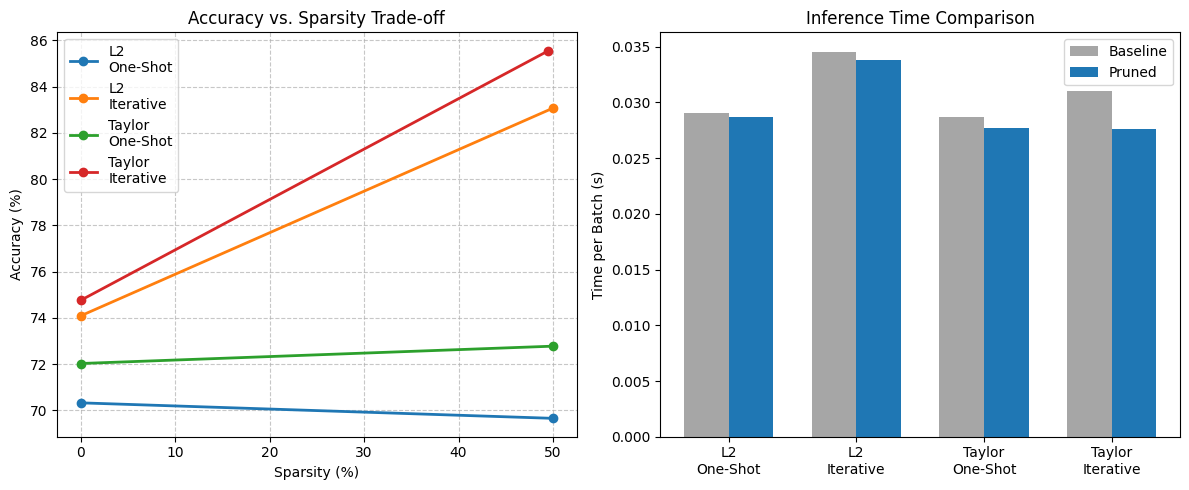

In [6]:
print("\n" + "="*105)
print(f"{'Type':<10} | {'Method':<8} | {'Strategy':<10} | {'Acc (%)':<8} | {'Sparsity':<10} | {'Comp. Size (MB)':<15} | {'Time (s)':<8}")
print("-" * 105)
for i, r in enumerate(all_results):
    print(f"{r['Type']:<10} | {r['Method']:<8} | {r['Strategy']:<10} | {r['Acc']:<8.2f} | {r['Sparsity']:<10.2f} | {r['Size']:<15.2f} | {r['Time']:<8.4f}")
    if i % 2 == 1: print("-" * 105)
print("="*105)

def visualize_results(results):
    methods = []
    baseline_accs = []
    pruned_accs = []
    sparsities = []
    times_baseline = []
    times_pruned = []

    # Extract paired results
    for i in range(0, len(results), 2):
        base = results[i]
        pruned = results[i+1]

        label = f"{base['Method']}\n{base['Strategy']}"
        methods.append(label)
        baseline_accs.append(base['Acc'])
        pruned_accs.append(pruned['Acc'])
        sparsities.append(pruned['Sparsity'])
        times_baseline.append(base['Time'])
        times_pruned.append(pruned['Time'])

    # Plot 1: Accuracy vs Sparsity Trade-off
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for i in range(len(methods)):
        # Plot line from Baseline (0 sparsity) to Pruned (actual sparsity)
        plt.plot([0, sparsities[i]], [baseline_accs[i], pruned_accs[i]], marker='o', label=methods[i], linewidth=2)

    plt.title("Accuracy vs. Sparsity Trade-off")
    plt.xlabel("Sparsity (%)")
    plt.ylabel("Accuracy (%)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Plot 2: Inference Time Comparison
    plt.subplot(1, 2, 2)
    x = np.arange(len(methods))
    width = 0.35

    plt.bar(x - width/2, times_baseline, width, label='Baseline', color='gray', alpha=0.7)
    plt.bar(x + width/2, times_pruned, width, label='Pruned', color='#1f77b4')

    plt.title("Inference Time Comparison")
    plt.ylabel("Time per Batch (s)")
    plt.xticks(x, methods)
    plt.legend()

    plt.tight_layout()
    plt.show()

print("\nGenerating Visualization...")
visualize_results(all_results)